# Neural Language Model - Basic (Word Prediction Example)

In this example, I'll show an example of simple language model.<br>
In general, the language model is used for a variety of NLP tasks, such as, translation, transcription, summarization, question-answering, etc.

For the purpose of your beginning, here we just train language model for text generation (i.e, next word prediction) with primitive neural networks.

Unlike previous examples (from exercise 01 to 04), language model will recognize the order of words in the sequence. (You don't need other special architecture to detect the sequence of words, such as 1D convolution, any more.)<br>
RNN-based specialized architecture (such as, LSTM, GRU, etc) can also be used to train in advanced language model. Furthermore, a lot of transformer-based algorithms are widely used in today's SOTA language models.<br>
You will see these advanced language models in the later exercises. (See exercise 06 - 09.)<br>
In this example, I'll briefly apply primitive feed-forward networks.

See the following diagram for entire network in this primitive example.<br>
First in this network, the sequence of last 5 words is embedded into the list of vectors. Embedded vectors are then concatenated into a single vector, and this vector is used for the next word's prediction.

![Model in this exercise](images/language_model_beginning.png)

Thereby, I note that this model won't care the long past context.<br>
For example, even when the following sentence is given, 

"In the United States, the president has now been"

it won't care the context "In the United States" when it refers the last 5 words in the network. (It might then predict the incorrect word in this context and the accuracy won't also be so high in this example. In the later examples, we will address this problem.)

Nevertheless, the neural language models will be well-generalized more than traditional statistical models for unseen data. For instance, if "red shirt" and "blud shirt" occurs in training set, "green shirt" (which is not seen in training set) will also be predicted by the trained neural model, because the model knows that "red", "blue", and "green" occur in the same context.

As you can see in this example, the language model can be trained with large unlabeled data (not needing for the labeled data), and this approach is very important for the growth of today's neural language models. This learning method is called **self-supervised learning**.<br>
A lot of today's SOTA algorithms (such as, BERT, T5, GPT-2, etc) learn a lot of language properties with large corpus in this unsupervised way (such as, masked word's prediction, next word's prediction), and can then be fine-tuned for specific downstream tasks with small amount of labeled data by transfer approach.

As you saw in [custom embedding example](./02_custom_embedding.ipynb), the word embedding will also be a byproduct in this example.

> Note : In these examples of this repository, I'll apply **word-level (word-to-word)** tokenization, but you can also use **character-level (character-to-character)** model, which can learn unseen words with signals - such as, prefixes (e.g, "un...", "dis..."), suffixes (e.g, "...ed", "...ing"), capitalization, or presence of certain characters (e.g, hyphen, digits), etc.<br>
> Subword tokenization is the popular method used in today's architecture (such as, Byte Pair Encoding in GPT-2), in which a set of commonly occurring word segments (like "cious", "ing", "pre", etc) is involved in a vocabulary list.<br>
> See [here](https://tsmatz.wordpress.com/2022/10/24/huggingface-japanese-ner-named-entity-recognition/) for SentencePiece tokenization in non-English languages.

*back to [index](https://github.com/tsmatz/nlp-tutorials/)*

## Install required packages

In [15]:
!pip install torch pandas numpy nltk

## Prepare data

Same as [this example](./03_word2vec.ipynb), here I also use short description text in news papers dataset.<br>
Before starting, please download [News_Category_Dataset_v2.json](https://www.kaggle.com/datasets/rmisra/news-category-dataset/versions/2) (collected by HuffPost) in Kaggle.

In [16]:
import pandas as pd

df = pd.read_json("News_Category_Dataset_v2.json",lines=True)
max_len = 10000
train_data = df["short_description"].iloc[:max_len]
train_data.shape

(10000,)

To get the better performance (accuracy), we standarize the input text as follows.
- Make all words to lowercase in order to reduce words
- Make "-" (hyphen) to space
- Remove all punctuation except " ' " (e.g, Ken's bag) and "&" (e.g, AT&T)

In [17]:
train_data = train_data.str.lower()
train_data = train_data.str.replace("-", " ", regex=True)
train_data = train_data.str.replace(r"[^'\&\w\s]", "", regex=True)
train_data = train_data.str.strip()
train_data

0       she left her husband he killed their children ...
1                                 of course it has a song
2       the actor and his longtime girlfriend anna ebe...
3       the actor gives dems an ass kicking for not fi...
4       the dietland actress said using the bags is a ...
                              ...                        
9995    by frannie ucciferri common sense media what i...
9996    lead us not into temptation isn't a good versi...
9997    by helen li in 2017 the campaign for virginia ...
9998    dont kid yourself 2016 was a revolutionary yea...
9999    tracey oliver says the industry is more open t...
Name: short_description, Length: 10000, dtype: object

Finally we add ```<start>``` and ```<end>``` tokens in each sequence as follows, because these are important information for learning the ordered sequence.

```this is a pen``` --> ```<start> this is a pen <end>```

In [18]:
train_data = [" ".join(["<start>", x, "<end>"]) for x in train_data]
# print first row
train_data[0]

'<start> she left her husband he killed their children just another day in america <end>'

## Generate sequence inputs

Same as in previous examples, we will generate the sequence of word's indices (i.e, tokenize) from text.

![Index vectorize](images/index_vectorize.png)

First we create a list of vocabulary (```vocab```).

In [19]:
from nltk.tokenize import SpaceTokenizer

###
# define Vocab
###
class Vocab:
    def __init__(self, list_of_sentence, tokenization, special_token, max_tokens=None):
        # count vocab frequency
        vocab_freq = {}
        tokens = tokenization(list_of_sentence)
        for t in tokens:
            for vocab in t:
                if vocab not in vocab_freq:
                    vocab_freq[vocab] = 0 
                vocab_freq[vocab] += 1
        # sort by frequency
        vocab_freq = {k: v for k, v in sorted(vocab_freq.items(), key=lambda i: i[1], reverse=True)}
        # create vocab list
        self.vocabs = [special_token] + list(vocab_freq.keys())
        if max_tokens:
            self.vocabs = self.vocabs[:max_tokens]
        self.stoi = {v: i for i, v in enumerate(self.vocabs)}

    def _get_tokens(self, list_of_sentence):
        for sentence in list_of_sentence:
            tokens = tokenizer.tokenize(sentence)
            yield tokens

    def get_itos(self):
        return self.vocabs

    def get_stoi(self):
        return self.stoi

    def append_token(self, token):
        self.vocabs.append(token)
        self.stoi = {v: i for i, v in enumerate(self.vocabs)}

    def __call__(self, list_of_tokens):
        def get_token_index(token):
            if token in self.stoi:
                return self.stoi[token]
            else:
                return 0
        return [get_token_index(t) for t in list_of_tokens]

    def __len__(self):
        return len(self.vocabs)

###
# generate Vocab
###
max_word = 50000

# create tokenizer
tokenizer = SpaceTokenizer()

# define tokenization function
def yield_tokens(data):
    for text in data:
        tokens = tokenizer.tokenize(text)
        yield tokens

# build vocabulary list
vocab = Vocab(
    train_data,
    tokenization=yield_tokens,
    special_token="<unk>",
    max_tokens=max_word,
)

# get list for index-to-word, and word-to-index.
itos = vocab.get_itos()
stoi = vocab.get_stoi()

In this example, we separate each sentence into 5 preceding word's sequence and word label (total 6 words) as follows.

![Separate words](images/separate_sequence_for_next_words.png)

In [20]:
import numpy as np

seq_len = 5 + 1
input_seq = []
for s in train_data:
    token_list = vocab(tokenizer.tokenize(s))
    for i in range(seq_len, len(token_list) + 1):
        seq_list = token_list[i-seq_len:i]
        input_seq.append(seq_list)
print("The number of training input sequence :{}".format(len(input_seq)))
input_seq = np.array(input_seq)

The number of training input sequence :109134


In [21]:
token_list


[1,
 7724,
 2868,
 56,
 3,
 922,
 10,
 48,
 365,
 5,
 107,
 450,
 2962,
 141,
 3,
 1081,
 1186,
 2]

In [22]:
input_seq[-2]


array([ 450, 2962,  141,    3, 1081, 1186])

Separate into inputs and labels.

In [23]:
X, y = input_seq[:,:-1], input_seq[:,-1]

In [24]:
X

array([[   1,   49,  333,   39,  832],
       [  49,  333,   39,  832,   19],
       [ 333,   39,  832,   19,  269],
       ...,
       [ 107,  450, 2962,  141,    3],
       [ 450, 2962,  141,    3, 1081],
       [2962,  141,    3, 1081, 1186]])

In [25]:
y

array([  19,  269,   51, ..., 1081, 1186,    2])

Dataset reduced to 10k sequences.

### Model Summary & Configuration

#### **1. Architecture**
The model is a simple **Feed-Forward Neural Network (FNN)** for next-word prediction.
*   **Input Layer**: Accepts a sequence of 5 integer indices representing the context words.
*   **Embedding Layer**: Converts word indices into dense vectors of size `embedding_dim` (64).
*   **Flatten**: Concatenates the embedded vectors of the 5 context words into a single vector.
*   **Hidden Layer**: A Linear layer mapping the flattened input to a `hidden_dim` (256), followed by a **ReLU** activation.
*   **Output Layer**: A Linear layer mapping the hidden representation to the vocabulary size (`vocab_size`), outputting logits for each word in the vocabulary.

#### **2. Pipeline Steps**
1.  **Data Loading**: Load news headlines from `News_Category_Dataset_v2.json`.
2.  **Preprocessing**:
    *   Convert to lowercase.
    *   Replace hyphens with spaces.
    *   Remove punctuation (keeping apostrophes and ampersands).
    *   Add `<start>` and `<end>` tokens.
3.  **Tokenization**: Create a vocabulary (max 50,000 words) and map words to integer indices.
4.  **Sequence Generation**: Create sliding windows of length 6 (5 context words + 1 target word).
5.  **Training**: Optimize the model using Cross Entropy Loss and AdamW optimizer.
6.  **Inference (Generation)**: Use **Greedy Search** to predict the next word iteratively.

#### **3. Hyperparameters & Parameters**
| Parameter | Value | Description |
| :--- | :--- | :--- |
| **Context Window** | 5 | Number of previous words used to predict the next word. |
| **Max Vocabulary** | 50,000 | Maximum number of unique words tracked. |
| **Embedding Dim** | 64 | Size of the vector representation for each word. |
| **Hidden Dim** | 256 | Size of the hidden layer in the feed-forward network. |
| **Batch Size** | 512 | Number of samples processed before updating weights. |
| **Learning Rate** | 0.001 | Step size for the AdamW optimizer. |
| **Epochs** | 30 | Number of complete passes through the training dataset. |

## Build network

Now we build network for our primitive language model. (See above for details about this model.)

![Model in this exercise](images/language_model_beginning.png)

In [26]:
import torch
import torch.nn as nn

embedding_dim = 64

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class SimpleLM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim=256):
        super().__init__()

        self.embedding = nn.Embedding(
            vocab_size,
            embedding_dim,
        )
        self.hidden = nn.Linear(embedding_dim*(seq_len - 1), hidden_dim)
        self.classify = nn.Linear(hidden_dim, vocab_size)
        self.relu = nn.ReLU()

    def forward(self, inputs):
        outs = self.embedding(inputs)
        outs = torch.flatten(outs, start_dim=1)
        outs = self.hidden(outs)
        outs = self.relu(outs)
        logits = self.classify(outs)
        return logits

model = SimpleLM(vocab.__len__(), embedding_dim).to(device)

Now let's generate text with this model.<br>
The generated result is messy, because it's still not trained at all.

In [74]:
start_index = stoi["<start>"]
end_index = stoi["<end>"]
max_output = 256

def pred_output(sentence, progressive_output=True):
    test_seq = vocab(tokenizer.tokenize(sentence))
    test_seq.insert(0, start_index)
    for loop in range(max_output):
        input_tensor = torch.tensor([test_seq[-5:]], dtype=torch.int64).to(device)
        pred_logits = model(input_tensor)
        pred_index = pred_logits.argmax()
        test_seq.append(pred_index.item())
        if progressive_output:
            for i in test_seq:
                print(itos[i], end=" ")
            print("\n")
        if pred_index.item() == end_index:
            break
    test_str = ""
    for i in test_seq:
        test_str += itos[i] +" "
    
    return test_str

pred_output("in the united states president", progressive_output=False)


'<start> in the united states president said attorney is still down this following <end> '

## Train

Now let's train our network.

Here I have just used loss and accuracy for evaluation, but the metrics to evaluate text generation task is not so easy. (Because simply checking an exact match to a reference text is not optimal.)<br>
In practice, use some common metrics available in language models, such as, **BLEU** or **ROUGE**. (See [here](https://tsmatz.wordpress.com/2022/11/25/huggingface-japanese-summarization/) for these metrics.)

In [28]:
from torch.utils.data import DataLoader
from torch.nn import functional as F
import time
import math

num_epochs = 30

dataloader = DataLoader(
    list(zip(y, X)),
    batch_size=512,
    shuffle=True,
)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

# lists to track history
loss_history = []
acc_history = []
ppl_history = []

# track time
start_time = time.time()

for epoch in range(num_epochs):
    running_loss = 0.0
    running_correct = 0
    total_samples = 0
    
    for labels, seqs in dataloader:
        seqs = seqs.to(device)
        labels = labels.to(device)
        
        # optimize
        optimizer.zero_grad()
        logits = model(seqs)
        loss = F.cross_entropy(logits, labels)
        loss.backward()
        optimizer.step()
        
        # accum stats (summing mean batch losses)
        running_loss += loss.item()
        
        # calculate accuracy
        pred_labels = logits.argmax(dim=1)
        running_correct += (pred_labels == labels).float().sum().item()
        total_samples += labels.size(0)

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = running_correct / total_samples
    epoch_ppl = math.exp(epoch_loss)
    
    loss_history.append(epoch_loss)
    acc_history.append(epoch_acc)
    ppl_history.append(epoch_ppl)

    print("Epoch {} - loss: {:2.4f} - accuracy: {:2.4f} - perplexity: {:2.4f}".format(epoch+1, epoch_loss, epoch_acc, epoch_ppl))

end_time = time.time()
print(f"Total Training Time: {end_time - start_time:.2f} seconds")

Epoch 1 - loss: 7.2811 - accuracy: 0.0940 - perplexity: 1452.5139
Epoch 2 - loss: 6.2124 - accuracy: 0.1176 - perplexity: 498.8846
Epoch 3 - loss: 5.5007 - accuracy: 0.1334 - perplexity: 244.8511
Epoch 4 - loss: 4.4241 - accuracy: 0.1888 - perplexity: 83.4355
Epoch 5 - loss: 3.4109 - accuracy: 0.3426 - perplexity: 30.2932
Epoch 6 - loss: 2.9355 - accuracy: 0.4042 - perplexity: 18.8311
Epoch 7 - loss: 2.6514 - accuracy: 0.4461 - perplexity: 14.1739
Epoch 8 - loss: 2.4346 - accuracy: 0.4807 - perplexity: 11.4118
Epoch 9 - loss: 2.2551 - accuracy: 0.5100 - perplexity: 9.5363
Epoch 10 - loss: 2.1055 - accuracy: 0.5352 - perplexity: 8.2113
Epoch 11 - loss: 1.9728 - accuracy: 0.5597 - perplexity: 7.1907
Epoch 12 - loss: 1.8563 - accuracy: 0.5813 - perplexity: 6.3997
Epoch 13 - loss: 1.7474 - accuracy: 0.6020 - perplexity: 5.7397
Epoch 14 - loss: 1.6522 - accuracy: 0.6212 - perplexity: 5.2182
Epoch 15 - loss: 1.5601 - accuracy: 0.6391 - perplexity: 4.7595
Epoch 16 - loss: 1.4767 - accuracy: 0

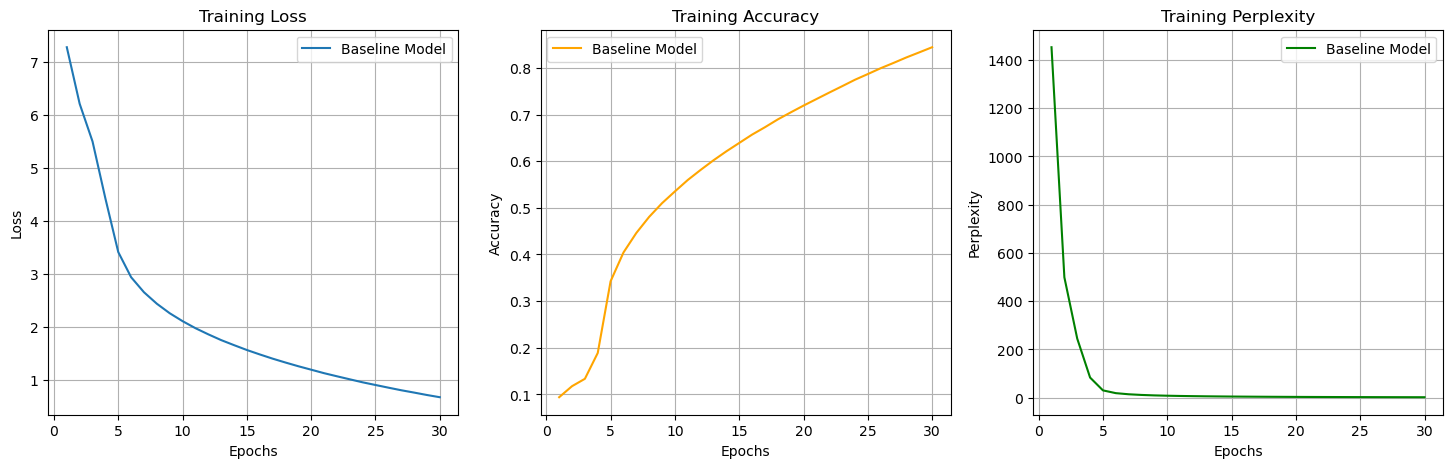

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 5))

# Plot Loss
plt.subplot(1, 3, 1)
plt.plot(range(1, num_epochs + 1), loss_history, label='Baseline Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 3, 2)
plt.plot(range(1, num_epochs + 1), acc_history, label='Baseline Model', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.grid(True)

# Plot Perplexity
plt.subplot(1, 3, 3)
plt.plot(range(1, num_epochs + 1), ppl_history, label='Baseline Model', color='green')
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.title('Training Perplexity')
plt.legend()
plt.grid(True)

plt.show()

# Generate text

In this example, I'll just show you how it generates a sentence by predicting the possibility of vocabularies over the given recent 5 words, until predicting the end-of-sequence.<br>
As I have mentioned above, I note that this model doesn't recognize the past context, because this model refers only last 5 words.

> Note : This approach - which repeatedly picks up the next word with maximum probability in each timestep and generates a consequent sentence - is called **greedy search**. For instance, when it retrieves the next word with probability 0.8 and the second next word with probability 0.2, the joint probability will then be 0.8 x 0.2 = 0.16. On the other hand, when it retrieves the next word with smaller probability 0.6 but the second next word with so higher probability 0.9, the joint probability becomes 0.54 and it's then be larger than the former one. This example shows that the greedy search algorithm may sometimes lead to sub-optimal solutions (i.e, label-bias problems). It's known that this algorithm also tends to produce repetitive outputs.<br>
> For this reason, greedy search algorithm is rarely used in practical inference in language models, and a popular method known as **beam search** is used to get more optimal solutions in production.<br>
> For simplification, **here I use greedy search algorithm for all examples in this repository**.

In [34]:
print(pred_output("in the united states president", progressive_output=False))
print(pred_output("the man has accused by", progressive_output=False))
print(pred_output("now he was expected to", progressive_output=False))

<start> in the united states president said 

<start> in the united states president said attorney 

<start> in the united states president said attorney is 

<start> in the united states president said attorney is still 

<start> in the united states president said attorney is still down 

<start> in the united states president said attorney is still down this 

<start> in the united states president said attorney is still down this following 

<start> in the united states president said attorney is still down this following <end> 

<start> the man has accused by gun 

<start> the man has accused by gun violence 

<start> the man has accused by gun violence and 

<start> the man has accused by gun violence and take 

<start> the man has accused by gun violence and take others 

<start> the man has accused by gun violence and take others little 

<start> the man has accused by gun violence and take others little a 

<start> the man has accused by gun violence and take others little a d

In the following exercises, I'll refine language models step-by-step.

In [36]:
torch.save(model.state_dict(), "modelnn.pkl")



In [ ]:
model = SimpleLM(vocab.__len__(), embedding_dim).to(device)
model.load_state_dict(torch.load("modelnn.pkl", map_location=device))
model.eval()

In [75]:
test_sentences = [
    "The actor released a statement denying the sexual harassment accusations ",
    "A new Star Wars film is reportedly",
    "The government failed to locate the immigrant children",
    "Trump gives Dems an ass-kicking for not having",
    "The pop star also left her",
    "Irish women will travel to vote in the",
    "Thousands of children deserve to be more",
    "The rural region said it is coming to",
    "Wiretaps reveal conversations between",
    "Activists are protesting the new law regarding",
"The former president shared his",
"California is the first state to legalize"
]

test_sentences = [sentence.lower() for sentence in test_sentences]
test_sentences = [sentence.replace("-", " ") for sentence in test_sentences]
test_sentences = [sentence.replace(r"[^'\&\w\s]", "") for sentence in test_sentences]
test_sentences = [sentence.strip() for sentence in test_sentences]

for sentence in test_sentences:
    print(pred_output(sentence, progressive_output=False))

<start> the actor released a statement denying the sexual harassment accusations after his 2017 their campaign <end> 
<start> a new star wars film is reportedly in a new case    played for justice <end> 
<start> the government failed to locate the immigrant children killed up the case of age was black man who went to be in the united states to talk the millions of the country he says his his solo performance <end> 
<start> trump gives dems an ass kicking for not having hard <end> 
<start> the pop star also left her the first black woman to receive the cecil b demille award <end> 
<start> irish women will travel to vote in the us history of my federal judge <end> 
<start> thousands of children deserve to be more than another statistic <end> 
<start> the rural region said it is coming to close the inquiry into russia's election meddling <end> 
<start> wiretaps reveal conversations between president donald trump were still talking <end> 
<start> activists are protesting the new law regard